<a href="https://colab.research.google.com/github/Jeongrnin/Computer-vision/blob/TransferLearning/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Settings

1) Important required libraries

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

2) Hyperparameter

In [9]:
batch_size= 16
learning_rate = 0.0001
epoch = 20

n_node = 1024
dropratio = 0.5

imgsize = 256

2. Data Loader

트레이닝 데이터

In [10]:
img_dir = "flower/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),

    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                              shuffle=True, num_workers=2)

80


고정된 데이터 셋

In [11]:
# 2. Dev data
img_dir = "flower/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)

# 3. Test data
img_dir = "flower/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                             shuffle=False, num_workers=2)

nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
      %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# for imgs, labels in train_batch:
#   for j in range(len(imgs)):
#     img = transforms.ToPILImage()(imgs[j])
#     plt.title("label: %d" % labels[j])
#     plt.imshow(img)
#     plt.show()

# of classes: 2
['AlceaRosea', 'HibiscusSyriacus']
{'AlceaRosea': 0, 'HibiscusSyriacus': 1}
80
Training: 80, Dev: 16, Test: 40


In [12]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['AlceaRosea', 'HibiscusSyriacus']
['AlceaRosea', 'HibiscusSyriacus']
['AlceaRosea', 'HibiscusSyriacus']


3. Model

1) Pretrained VGG Model

In [13]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
  print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 63.3MB/s]


features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [14]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


2) Customized Fully Model

In [15]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
  def __init__(self):
    super(MyVGG, self).__init__()
    self.layer0 = nn.Sequential(*list(vgg.children())[0])
    self.layer1 = nn.Sequential(
        nn.Linear(8*base_dim * fsize * fsize, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, nclass)
    )
    # weight initialization
    for m in self.layer1.modules():
      #print(m)
      if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data) # RELU일 때
        m.bias.data.fill_(0)
      if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight.data)
        m.bias.data.fill_(0)
  def forward(self, x):
    out = self.layer0(x)
    # print(out.size())
    out = out.view(out.size(0), -1)
    out = self.layer1(out)
    return out

3) Model on GPU

In [16]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.requires_grad = False

for params in model.layer1.parameters():
    params.requires_grad = True

In [17]:
for name in model.children():
  print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

4. Optimizer & Loss

In [18]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

5. Train

In [25]:
import time
import torch
from torch.autograd import Variable
import utils

model.to("cuda")

total_time = 0
disp_step = 10

to_train = True

# 배치를 GPU로 옮기는 함수
def move_batch_to_cuda(batch):
    return [(img.cuda(), label.cuda()) for img, label in batch]

# 학습 및 평가 배치를 GPU로 옮김
train_batch = move_batch_to_cuda(train_batch)
dev_batch = move_batch_to_cuda(dev_batch)
test_batch = move_batch_to_cuda(test_batch)

if not to_train:
    netname = './nets/roseasyriacus_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" % (n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" % (train_corr, dev_corr, test_corr))
    model.train()

    netname = './nets/roseasyriacus_vgg19'

    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []

    x_epoch.append(0)
    y_train_err.append(100.0 - train_corr)
    y_dev_err.append(100.0 - dev_corr)
    y_test_err.append(100.0 - test_corr)

    for i in range(epoch):
        start_time = time.time()
        print("%d.." % i)
        for img, label in train_batch:
            img = img.cuda()
            label = label.cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i == epoch - 1):
            torch.save(model, netname + '_%d.pkl' % i)
            print("\n[%d/%d] loss: %.3f" % (i, epoch, loss.item()))

            model.eval()

            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f" % (train_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec.." % total_time)

            # graph 그리기
            x_epoch.append(i + 1)
            y_train_err.append(100.0 - train_corr)
            y_dev_err.append(100.0 - dev_corr)
            y_test_err.append(100.0 - test_corr)
    print("Total time: %.2f sec" % total_time)


3 layer, n_node: 1024, dropratio: 0.50


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Correct of train: 100.00, dev: 81.25, test: 80.00
0..

[0/20] loss: 0.019
Correct of train: 100.00, dev: 81.25, test: 80.00
time: 0.02 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.009
Correct of train: 100.00, dev: 75.00, test: 77.50
time: 4.99 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.013
Correct of train: 100.00, dev: 75.00, test: 77.50
time: 9.41 sec..
Total time: 9.41 sec


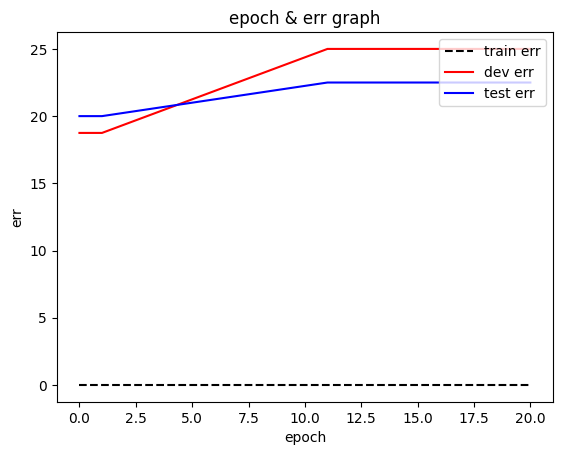

In [27]:
if (to_train):
  plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
  plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
  plt.plot(x_epoch, y_test_err, color='blue', label='test err')

  plt.xlabel('epoch')
  plt.ylabel('err')
  plt.title('epoch & err graph')
  plt.legend(loc="upper right")
  plt.show()

6. Evaluation for dev & test data

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


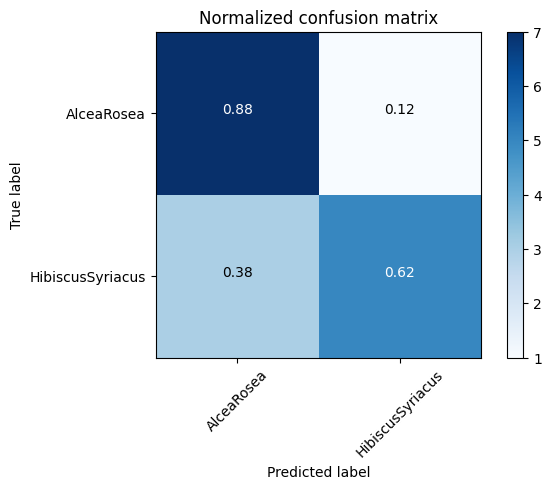

Confusion matrix, without normalization


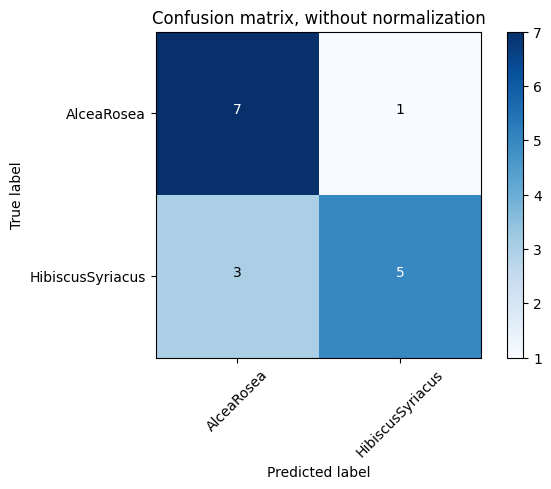

	 acc  |	 pre  |	 rec  |	 f1
 AlceaRosea: 0.75 |	 0.70 |	 0.88 |	 0.78
 HibiscusSyriacus: 0.75 |	 0.83 |	 0.62 |	 0.71
*accuracy: 0.75, precision: 0.77, recall: 0.75, *f1 score: 0.75
[AP]
AlceaRosea: 0.95
HibiscusSyriacus: 0.88

[mAP] 0.911
[miAP] 0.875


(array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.95762891, 0.96729994, 0.93156785, 0.98228419, 0.6697436 ,
        0.77751631, 0.84832489, 0.89822751, 0.59051692, 0.65238619,
        0.5330289 , 0.58486527, 0.55374336, 0.55231869, 0.79297549,
        0.82631993]))

In [28]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


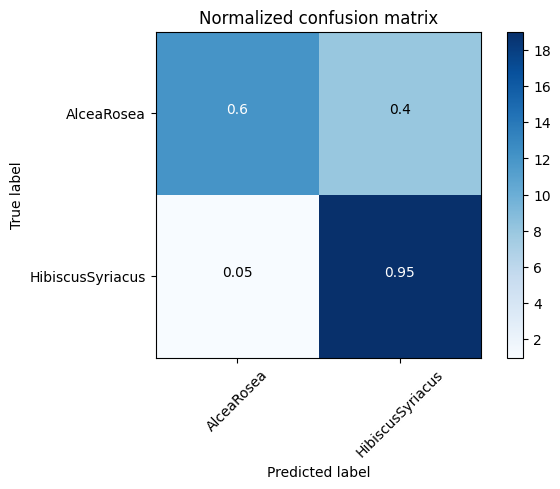

Confusion matrix, without normalization


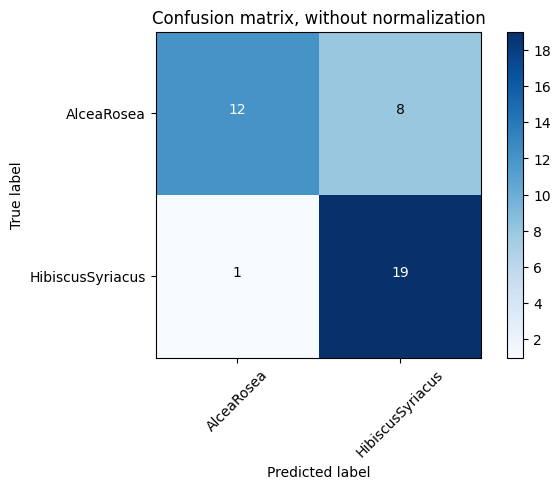

	 acc  |	 pre  |	 rec  |	 f1
 AlceaRosea: 0.78 |	 0.92 |	 0.60 |	 0.73
 HibiscusSyriacus: 0.78 |	 0.70 |	 0.95 |	 0.81
*accuracy: 0.78, precision: 0.81, recall: 0.77, *f1 score: 0.77
[AP]
AlceaRosea: 0.85
HibiscusSyriacus: 0.76

[mAP] 0.808
[miAP] 0.887


In [29]:
model. eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Category: AlceaRosea
 True predicted images/total AlceaRosea category: 7 / 8
Predicted probability:
[0.9576289  0.04237109]


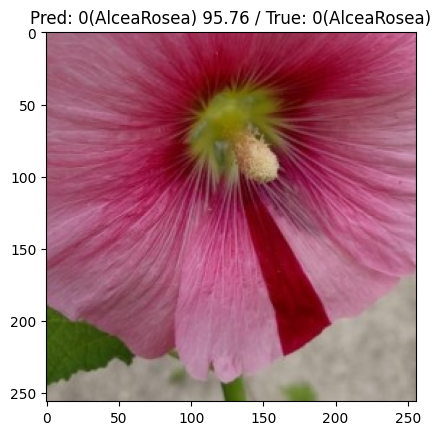

Predicted probability:
[0.96729994 0.03270008]


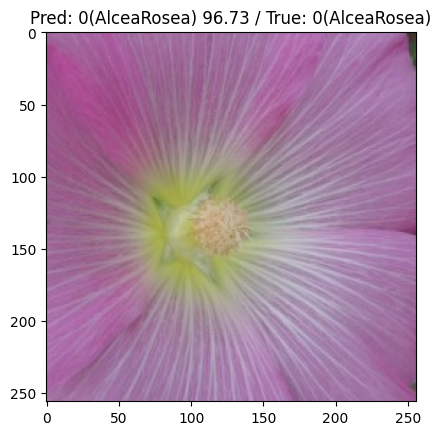

 False predicted images/total AlceaRosea category: 1 / 8
Predicted probability:
[0.22248371 0.7775163 ]


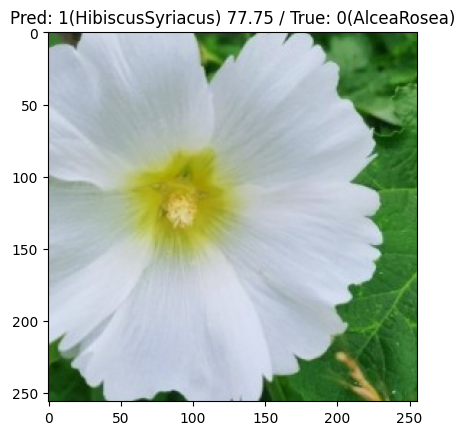

Category: HibiscusSyriacus
 True predicted images/total HibiscusSyriacus category: 5 / 8
Predicted probability:
[0.34761384 0.6523862 ]


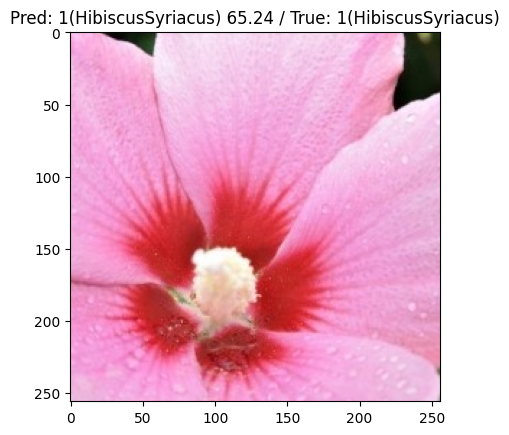

Predicted probability:
[0.44625664 0.55374336]


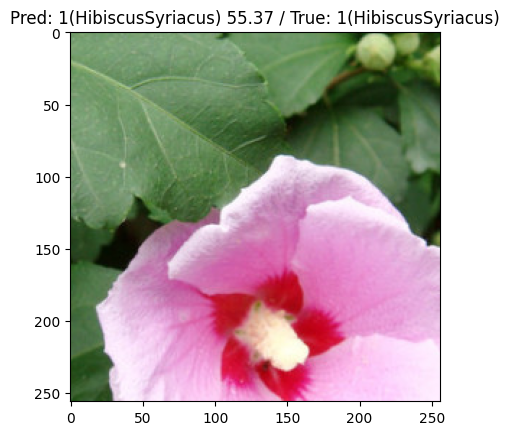

 False predicted images/total HibiscusSyriacus category: 3 / 8
Predicted probability:
[0.5905169  0.40948308]


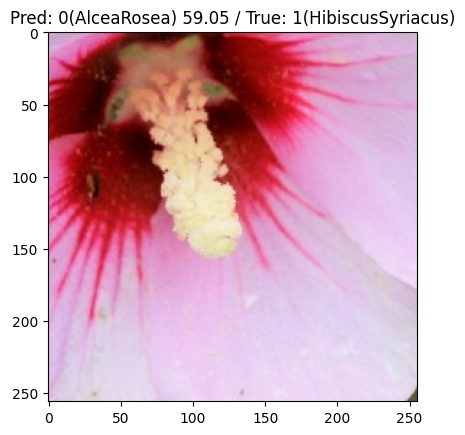

Predicted probability:
[0.5330289 0.4669711]


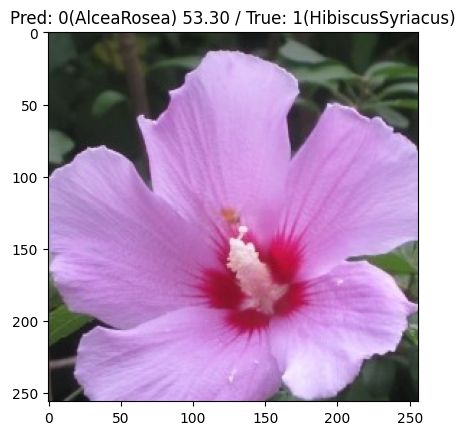

In [30]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)

Category: AlceaRosea
 True predicted images/total AlceaRosea category: 7 / 8
Predicted probability:
[0.9576289  0.04237109]


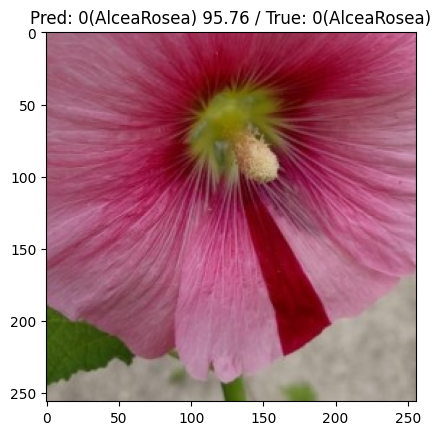

Predicted probability:
[0.96729994 0.03270008]


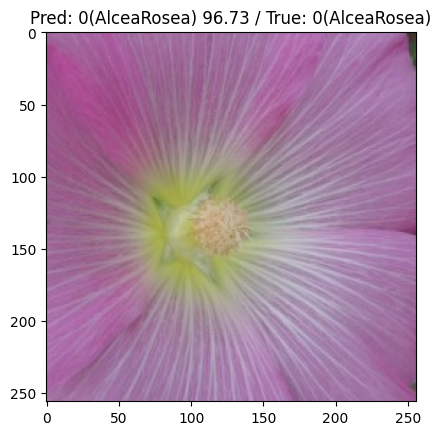

 False predicted images/total AlceaRosea category: 1 / 8
Predicted probability:
[0.22248371 0.7775163 ]


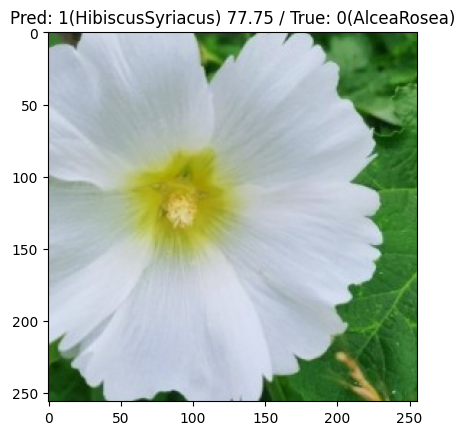

Category: HibiscusSyriacus
 True predicted images/total HibiscusSyriacus category: 5 / 8
Predicted probability:
[0.34761384 0.6523862 ]


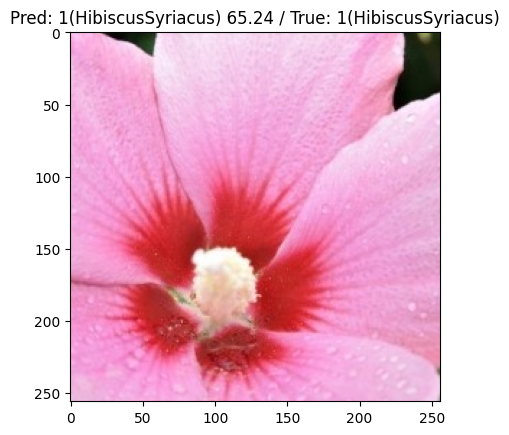

Predicted probability:
[0.44625664 0.55374336]


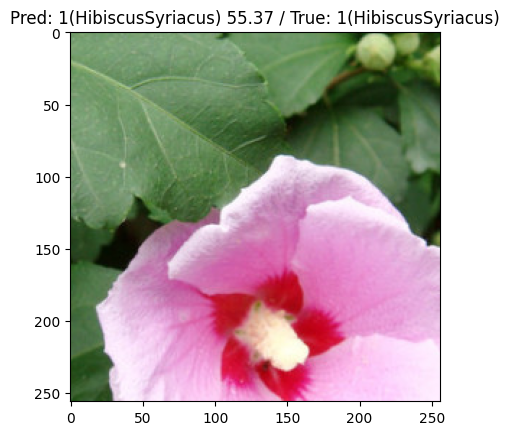

 False predicted images/total HibiscusSyriacus category: 3 / 8
Predicted probability:
[0.5905169  0.40948308]


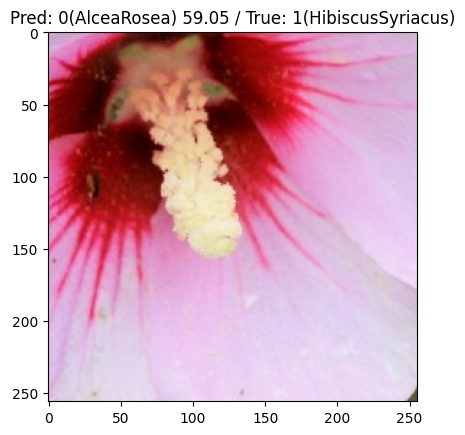

Predicted probability:
[0.5330289 0.4669711]


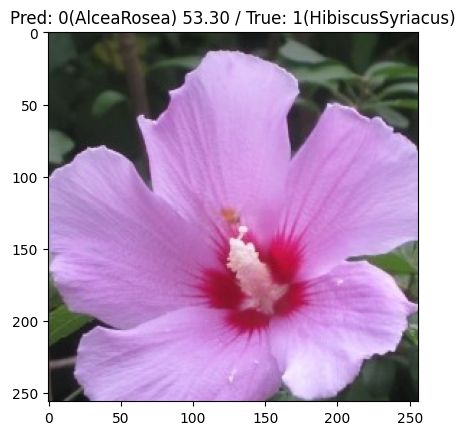

In [31]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)

Category: AlceaRosea
 True predicted images/total AlceaRosea category: 7 / 8
Predicted probability:
[0.9576289  0.04237109]


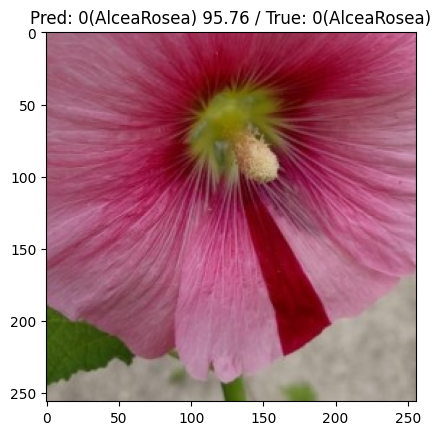

Predicted probability:
[0.96729994 0.03270008]


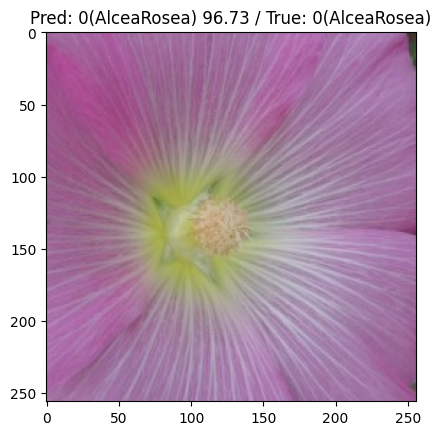

 False predicted images/total AlceaRosea category: 1 / 8
Predicted probability:
[0.22248371 0.7775163 ]


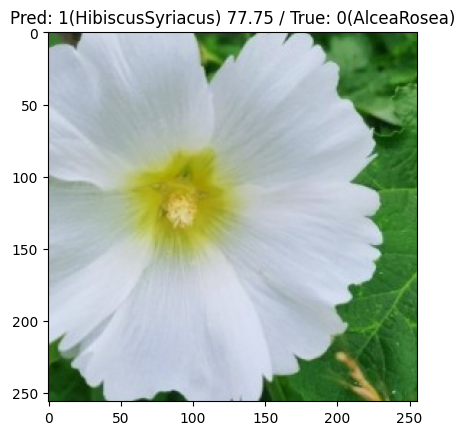

Category: HibiscusSyriacus
 True predicted images/total HibiscusSyriacus category: 5 / 8
Predicted probability:
[0.34761384 0.6523862 ]


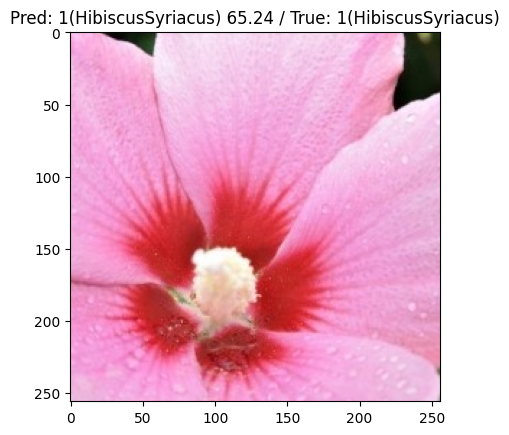

Predicted probability:
[0.44625664 0.55374336]


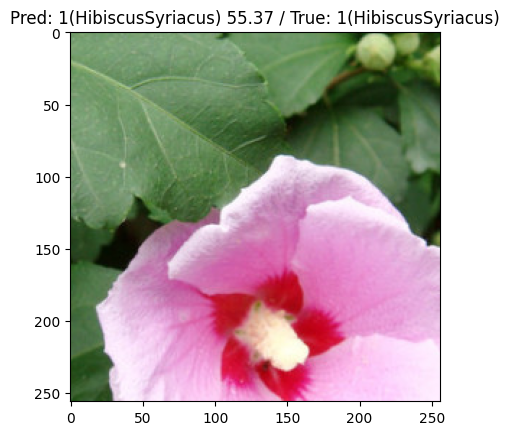

 False predicted images/total HibiscusSyriacus category: 3 / 8
Predicted probability:
[0.5905169  0.40948308]


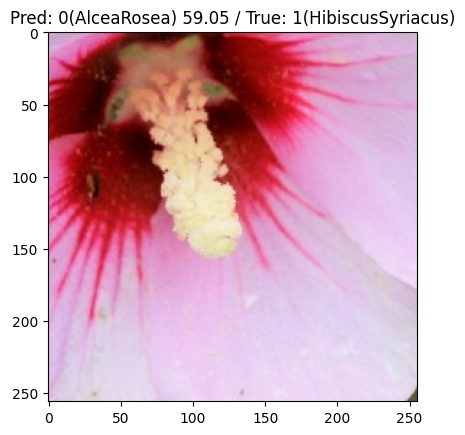

Predicted probability:
[0.5330289 0.4669711]


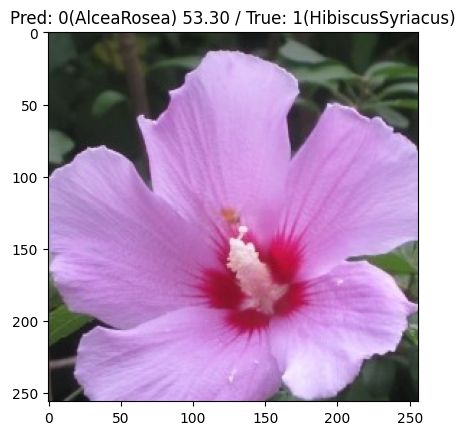

In [32]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)